In [1]:
import fastjet as fj
jet_R0 = 0.4
jet_def = fj.JetDefinition(fj.antikt_algorithm, jet_R0)
print(jet_def)
max_eta_hadron=1
parts_selector_h = fj.SelectorAbsEtaMax(max_eta_hadron)
jet_selector = fj.SelectorAbsEtaMax(max_eta_hadron - jet_R0 * 1.05)

Longitudinally invariant anti-kt algorithm with R = 0.4 and E scheme recombination


In [2]:
import hepmc2wrap
hepmcfile='/rstorage/ml/egml/data/jewel_pp/686906/1/jewel.hepmc'

In [3]:
from pyjetty.mputils import find_files
files = find_files('/rstorage/ml/egml/data/jewel_pp', '*.hepmc')
print('[i] found {} files'.format(len(files)))

Welcome to JupyROOT 6.24/02
[i] found 0 files


In [4]:
from tqdm.notebook import tqdm
jets = []
for hepmcile in tqdm(files[:3]):
    input_hepmc = hepmc2wrap.ReadHepMCFile(hepmcfile)
    final = True
    while input_hepmc.NextEvent():
        fjparts = []
        parts = input_hepmc.HepMCParticles(final)
        for part in parts:
            pid = part.pdg_id()
            psj = fj.PseudoJet(part.momentum().px(), part.momentum().py(), part.momentum().pz(), part.momentum().e())
            fjparts.append(psj)
            fjparts_sel = parts_selector_h(fjparts)
        # print('mult:', len(parts), len(fjparts_sel))
        _ = [jets.append(j) for j in jet_selector(jet_def(fjparts_sel))]

0it [00:00, ?it/s]

In [5]:
import matplotlib.pyplot as plt

In [6]:
def plot_jets(jets):
    n, bins, patches = plt.hist([j.pt() for j in jets], 10, density=1, facecolor='g', alpha=0.75, log=True)
    plt.ylabel('probability density')
    plt.show()
    zs = []
    njets = 0
    for j in jets:
        if j.pt() > 200 and j.pt() <  250:
            for c in j.constituents():
                zs.append(c.pt() / j.pt())
            njets = njets + 1
    n, bins, patches = plt.hist(zs, 10, density=True, facecolor='r', alpha=0.75, log=True)
    plt.ylabel('probability density')
    plt.show()
    return njets, zs

/data/software/ploskon/heppy/venv/heppy-9eJ8HWuE/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


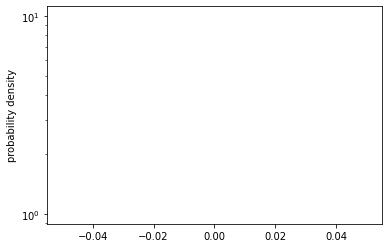

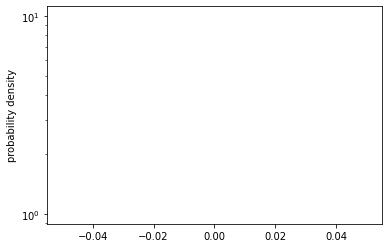

In [7]:
njets_hepmc, zs_hepmc = plot_jets(jets)

In [8]:
import pythia_init_util as pyut
import pythiafjext

In [9]:
pythia = pyut.pythia_init_from_string("--py-ecm 5000 --user-seed=100000 --nev 1000 --py-pthatmin 200 --py-hardQCD")

['HardQCD:all=on', 'PhaseSpace:pTHatMin = 200.0', 'Beams:eCM = 5000.0']
[i] strings read to PYTHIA  [['HardQCD:all=on', 'PhaseSpace:pTHatMin = 200.0', 'Beams:eCM = 5000.0', 'Next:numberCount = 0', 'Next:numberShowEvent = 0', 'Next:numberShowInfo = 0', 'Next:numberShowProcess = 0', 'Stat:showProcessLevel = on']]
[i] pythia initialized with ['HardQCD:all=on', 'PhaseSpace:pTHatMin = 200.0', 'Beams:eCM = 5000.0', 'Next:numberCount = 0', 'Next:numberShowEvent = 0', 'Next:numberShowInfo = 0', 'Next:numberShowProcess = 0', 'Stat:showProcessLevel = on']

 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |

In [ ]:
pyjets = []
for n in tqdm(range(1000)):
    if not pythia.next():
        continue
    parts_pythia_h = parts_selector_h(pythiafjext.vectorize_select(pythia, [pythiafjext.kFinal], 0, False))
    jets_h = fj.sorted_by_pt(jet_selector(jet_def(parts_pythia_h)))
    _ = [pyjets.append(j) for j in jets_h]

In [ ]:
njets_pythia, zs_pythia = plot_jets(pyjets)

In [ ]:
n, bins, patches = plt.hist([zs_hepmc, zs_pythia], 
                            20, 
                            label=['HEPMC', 'PYTHIA8'],
                            density=[True, True], 
                            alpha=0.75, log=True, histtype='step')
plt.ylabel('probability density')
plt.xlabel('z')
plt.title('jets 200-250 GeV/c')
plt.legend()
plt.show()